In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo import spa

from nengo_learn_assoc_mem.utils import BasicVecFeed, meg_from_spikes, make_fan_vocab

In [3]:
t_present = 0.3
t_pause = 0.1
dimensions = 32
n_neurons = 25
dt = 0.001
seed = 8

In [4]:
t_pres = int(t_present / dt)
t_paus = int(t_pause / dt)
slc_tm = (t_paus+t_pres)

In [5]:
vocab, fan1, fan1_vecs, fan1_labels, fan2, fan2_vecs, fan2_labels = make_fan_vocab(seed, dimensions)

c:\users\mr_bo\git\nengo\nengo\spa\vocab.py:114: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=10)
  len(self.pointers)))


In [6]:
all_vecs = np.concatenate((fan1_vecs, fan2_vecs))
simi = np.dot(all_vecs, all_vecs.T)
np.fill_diagonal(simi, 0.)
intercept = np.ceil(np.max(simi)*100)/100
print(intercept)

0.4


In [7]:
print(all_vecs.shape)
print(np.abs(np.sum(all_vecs, axis=1)))

(7, 32)
[ 0.1360335   1.56699049  0.01839462  1.12083417  0.19471319  1.51792888
  0.83293725]


In [8]:
all_labels = fan1_labels + fan2_labels

# Basic associative memory

In [86]:
data_feed = BasicVecFeed(all_vecs, all_vecs, t_present, dimensions, len(all_vecs), t_pause)

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)

    # Note: if the threshold is set too high, it won't respond even close to the MEG
    # because it will then ignore values that would otherwise be considered similar
    # so set it as low as possible to see MEG-like effects
    mem = nengo.networks.AssociativeMemory(all_vecs, n_neurons=n_neurons, threshold=0.1)
    
    nengo.Connection(stim, mem.input, synapse=None)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = []

    for am_ens in mem.am_ensembles:
        p_spikes.append(nengo.Probe(am_ens.neurons))

In [87]:
with nengo.Simulator(model) as sim:
    sim.run(len(all_labels)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:03.                                                                                         


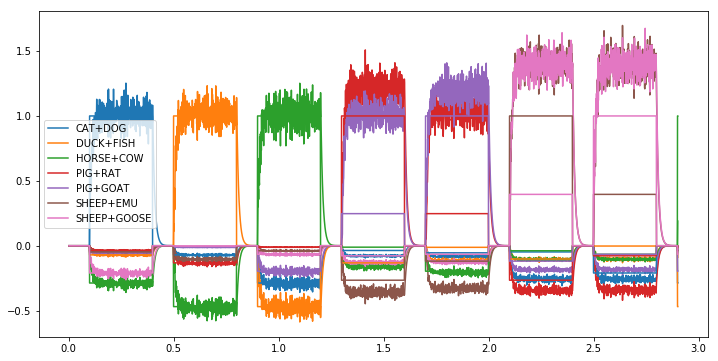

In [88]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], all_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], all_vecs))

plt.legend(all_labels)

In [89]:
ens_responses = [meg_from_spikes(sim.data[p_spk]) for p_spk in p_spikes]
resp_sum = np.sum(ens_responses, axis=0)

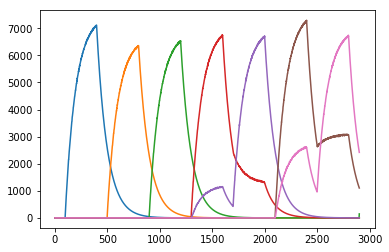

In [90]:
for ens_rep in ens_responses:
    plt.plot(ens_rep)

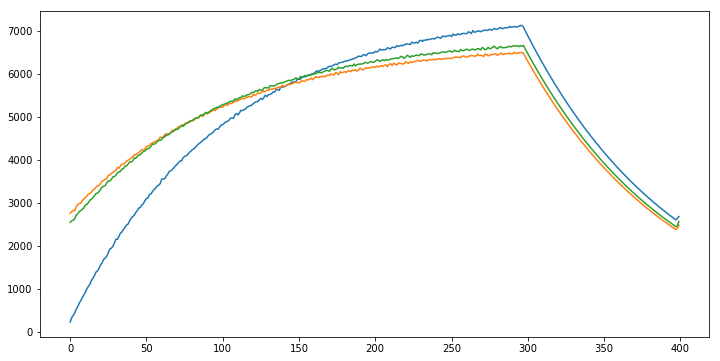

In [91]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)

fan1_resp = []

for t_p in range(t_paus, len(fan1)*slc_tm, slc_tm):
    fan1_resp.append(resp_sum[t_p:t_p+slc_tm])
    plt.plot(fan1_resp[-1])
    
fan1_resp = np.array(fan1_resp).T

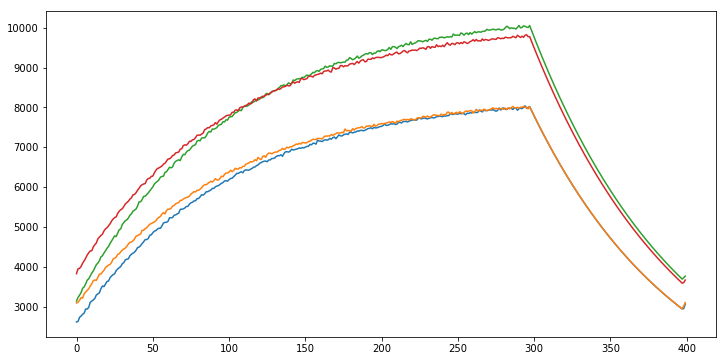

In [92]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)
fan2_resp = []

for t_p in range(t_paus+len(fan1)*slc_tm, (len(fan1)+len(fan2))*slc_tm, slc_tm):
    fan2_resp.append(resp_sum[t_p:t_p+slc_tm])
    plt.plot(fan2_resp[-1])

fan2_resp = np.array(fan2_resp).T

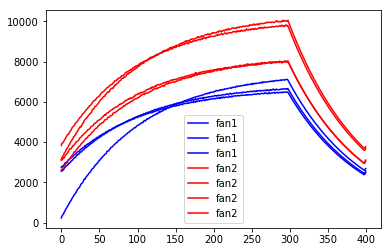

In [93]:
plt.plot(fan1_resp, color='blue', label="fan1")
plt.plot(fan2_resp, color='red', label="fan2")
plt.legend()

In [94]:
frog = vocab.parse("FROG").v
stim.output = lambda t: frog
correct.output = lambda t: frog

with nengo.Simulator(model) as sim:
    sim.run(t_present)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:01.                                                                                         


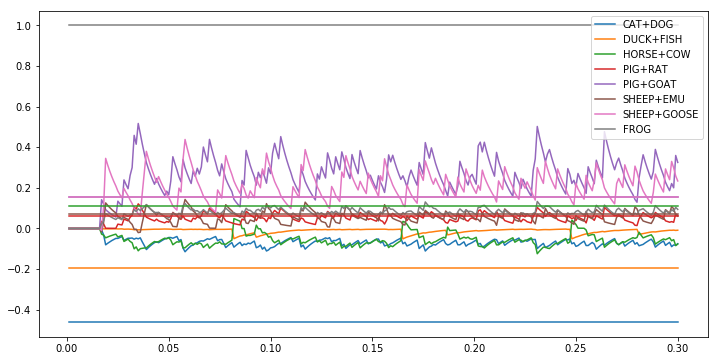

In [95]:
with_frog = np.concatenate((all_vecs, frog[None, :]), axis=0)

plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], with_frog))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], with_frog))

plt.legend(all_labels+["FROG"])

In [96]:
ens_responses = [
    meg_from_spikes(
        np.concatenate(
            (np.zeros((100, n_neurons)), sim.data[p_spk]), axis=0)
    ) for p_spk in p_spikes]

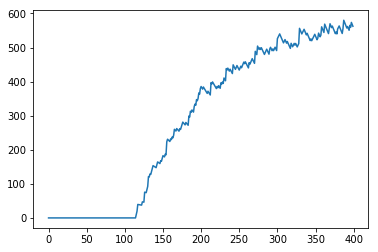

In [97]:
resp_sum = np.sum(ens_responses, axis=0)

plt.plot(resp_sum)

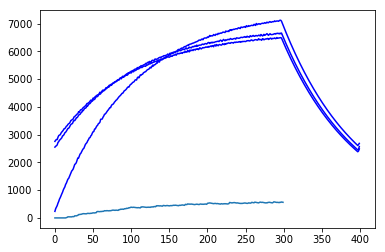

In [98]:
plt.plot(fan1_resp, color='blue', label="fan1")
plt.plot(resp_sum[100:])

# Basic voja memory

In [136]:
from nengo_learn_assoc_mem.learn_assoc import LearningAssocMem

n_neurons = 40
data_feed = BasicVecFeed(all_vecs, all_vecs, t_present, dimensions, len(all_vecs), t_pause)

def is_ans(t, x):
    if np.abs(np.sum(x)) > 0:
        return 1
    else:
        return -1

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)
    learn_control = nengo.Node(is_ans, size_in=dimensions)
    
    # Note: setting the intercept doesn't really change much, because there's so much similarity already
    mem = LearningAssocMem(n_neurons, dimensions, voja_rate=1e-5, pes_rate=1e-3, intercepts=np.ones(n_neurons)*0.1, seed=seed)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)

    nengo.Connection(correct, learn_control, synapse=None)
    nengo.Connection(learn_control, mem.stop_learn)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)

    p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=0.1)
    p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=0.1)

In [137]:
with nengo.Simulator(model) as sim:
    sim.run(len(all_labels)*(t_present+t_pause)*20 + t_pause)

Building finished in 0:00:01.                                                                                                                                   
Simulating finished in 0:00:21.                                                                                                                                 


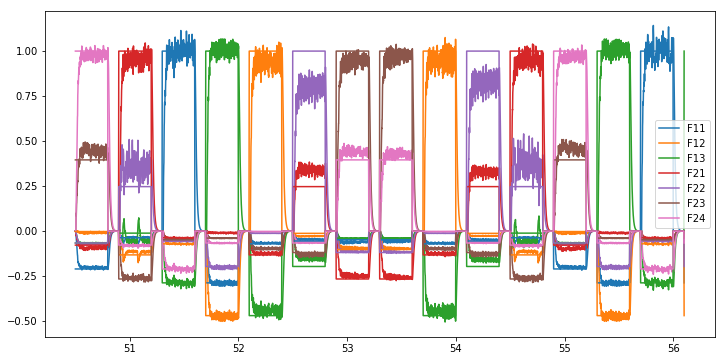

In [138]:
plt.figure(figsize=(12, 6))
win = int(len(all_labels)*(t_present+t_pause) / dt) * 2

t_win = sim.trange()[-win:]

plt.plot(t_win, spa.similarity(sim.data[p_rec][-win:], all_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(t_win, spa.similarity(sim.data[p_cor][-win:], all_vecs))

plt.legend(all_labels)

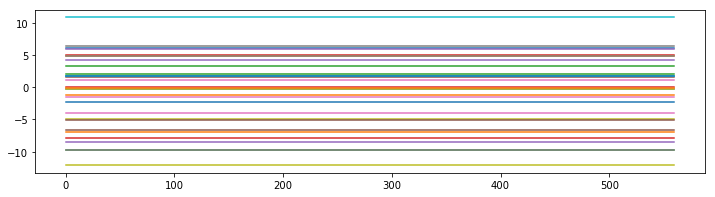

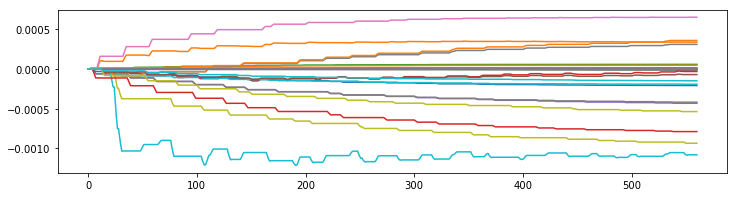

In [139]:
plt.figure(figsize=(12, 3))

plt.plot(sim.data[p_enc][:, 0, :]);

plt.figure(figsize=(12, 3))

plt.plot(sim.data[p_dec][:, 0, :]);

In [140]:
load_from = {}
load_from["enc"] = sim.data[p_enc][-1].copy()
load_from["dec"] = sim.data[p_dec][-1].copy()
load_from["seed"] = seed

with nengo.Network() as model:
    stim = nengo.Node(data_feed.feed)
    correct = nengo.Node(data_feed.get_answer)

    mem = LearningAssocMem(n_neurons, dimensions, voja_rate=0, pes_rate=0, load_from=load_from, intercepts=np.ones(n_neurons)*0.1)
    
    nengo.Connection(stim, mem.input, synapse=None)
    
    p_rec = nengo.Probe(mem.output, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)
    p_spikes = nengo.Probe(mem.mem.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(all_labels)*(t_present+t_pause) + t_pause)

Building finished in 0:00:01.                                                                                                                                   
Simulating finished in 0:00:01.                                                                                                                                 


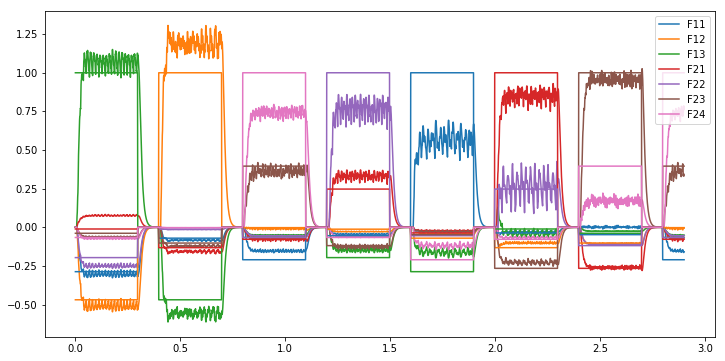

In [141]:
plt.figure(figsize=(12, 6))

plt.plot(sim.trange(), spa.similarity(sim.data[p_rec], all_vecs))

plt.gca().set_prop_cycle(None)

plt.plot(sim.trange(), spa.similarity(sim.data[p_cor], all_vecs))

plt.legend(all_labels)

In [142]:
ens_responses = meg_from_spikes(
    np.concatenate(
        (np.zeros((100, n_neurons)), sim.data[p_spikes]), axis=0)
)

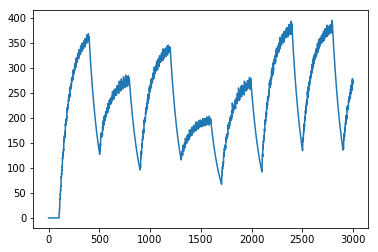

In [143]:
plt.plot(ens_responses)

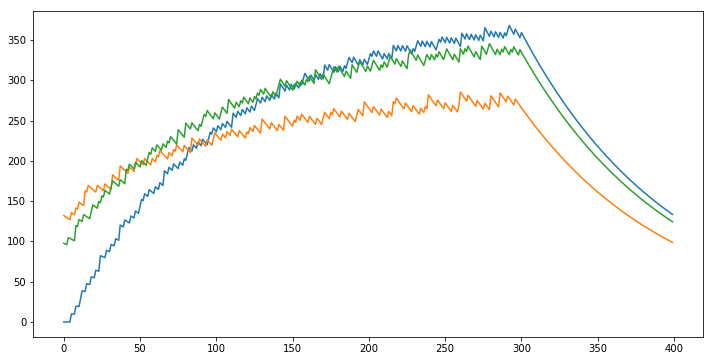

In [144]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)

fan1_resp = []

for t_p in range(t_paus, len(fan1)*slc_tm, slc_tm):
    fan1_resp.append(ens_responses[t_p:t_p+slc_tm])
    plt.plot(fan1_resp[-1])

fan1_resp = np.array(fan1_resp).T

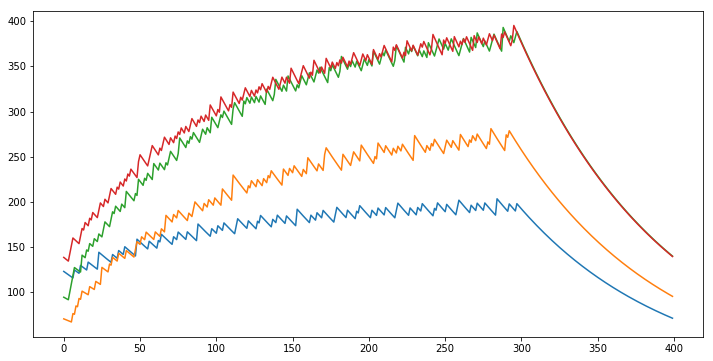

In [145]:
plt.figure(figsize=(12, 6))

t_pres = int(t_present / dt)
fan2_resp = []

for t_p in range(t_paus+len(fan1)*slc_tm, (len(fan1)+len(fan2))*slc_tm, slc_tm):
    fan2_resp.append(ens_responses[t_p:t_p+slc_tm])
    plt.plot(fan2_resp[-1])

fan2_resp = np.array(fan2_resp).T

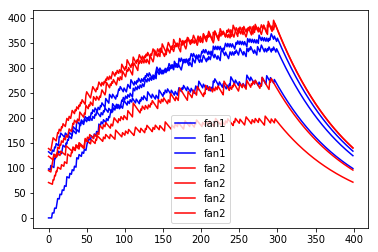

In [146]:
plt.plot(fan1_resp, color='blue', label="fan1")
plt.plot(fan2_resp, color='red', label="fan2")
plt.legend()

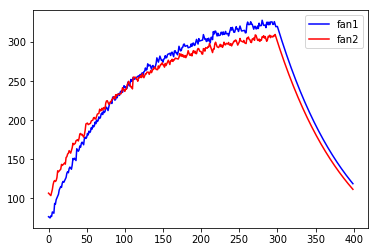

In [147]:
plt.plot(np.mean(fan1_resp, axis=1), color='blue', label="fan1")
plt.plot(np.mean(fan2_resp, axis=1), color='red', label="fan2")
plt.legend()

In [148]:
ens_responses = []

for foil in ("FROG", "TOAD", "NEWT", "ROACH"):
    f_vec = vocab.parse(foil).v
    stim.output = lambda t: f_vec
    correct.output = lambda t: f_vec

    with nengo.Simulator(model) as sim:
        sim.run(t_present)
    
    ens_responses.append(meg_from_spikes(
        np.concatenate(
            (np.zeros((100, n_neurons)), sim.data[p_spikes]), axis=0))
    )

ens_responses = np.array(ens_responses).T

Building finished in 0:00:01.                                                                                                                                   
Simulating finished in 0:00:01.                                                                                                                                 
Building finished in 0:00:01.                                                                                                                                   
Simulating finished in 0:00:01.                                                                                                                                 
Building finished in 0:00:01.                                                                                                                                   
Simulating finished in 0:00:01.                                                                                                                                 
Building finished in 0:00:01.     

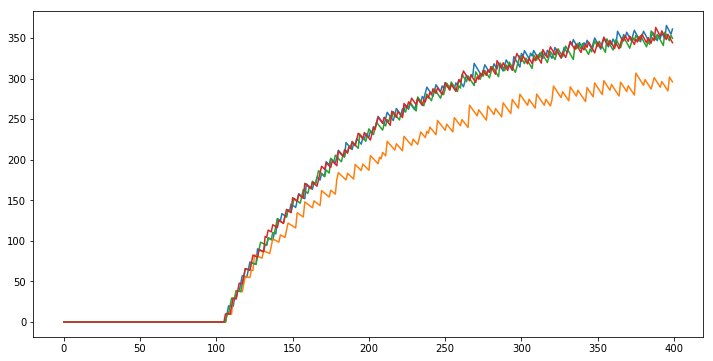

In [149]:
plt.figure(figsize=(12, 6))

plt.plot(ens_responses)

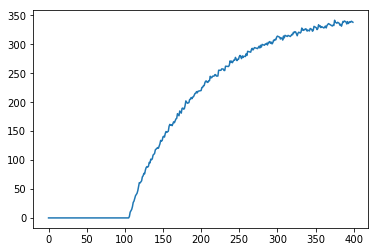

In [150]:
resp_mean = np.mean(ens_responses, axis=1)

plt.plot(resp_mean)

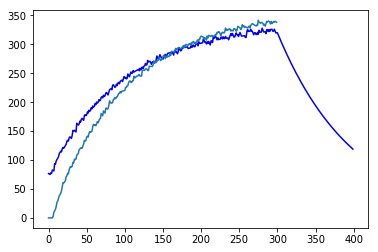

In [151]:
plt.plot(np.mean(fan1_resp, axis=1), color='blue', label="fan1")
plt.plot(resp_mean[100:])